In [1]:
import os 
import torch 
import fnmatch
from torch import nn
from PIL import Image
from torchvision import transforms 
from tqdm.auto import tqdm 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt 

C:\Users\Sania\gans-data-augmentation\gans_data_aug\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.distributions.kl import kl_divergence
from torch.distributions.normal import Normal

In [3]:
DATA_PATHS = {
    "dataset": "./dataset/", 
    "checkpoints": "./checkpoints/",
    "model": "./model"
}

In [4]:
class PetrolPumpDataset(Dataset): 
    def __init__(self, img_dir, transform=None, extensions=['*.jpg', '*.jpeg', '*.png']):
        self.extensions = extensions 
        self.img_dir = img_dir
        self.image_paths = [f"{img_dir}/{img}" for img in os.listdir(img_dir) if any(fnmatch.fnmatch(img, ext) for ext in extensions)]
        self.transform = transform 
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, idx): 
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform: 
            image = self.transform(image)
            
        return image

In [5]:
dataset = PetrolPumpDataset(DATA_PATHS["dataset"], transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
]))

In [6]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
img = next(iter(dataloader))
img[0].shape

torch.Size([3, 256, 256])

In [7]:
def show_tensor_images(image_tensor, num_images=1):
    image_tensor = image_tensor.detach().cpu()
    image_tensor = image_tensor.permute(1, 2, 0)

    # Handling normalization 
    image_tensor = torch.clamp(image_tensor, min=0, max=1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()


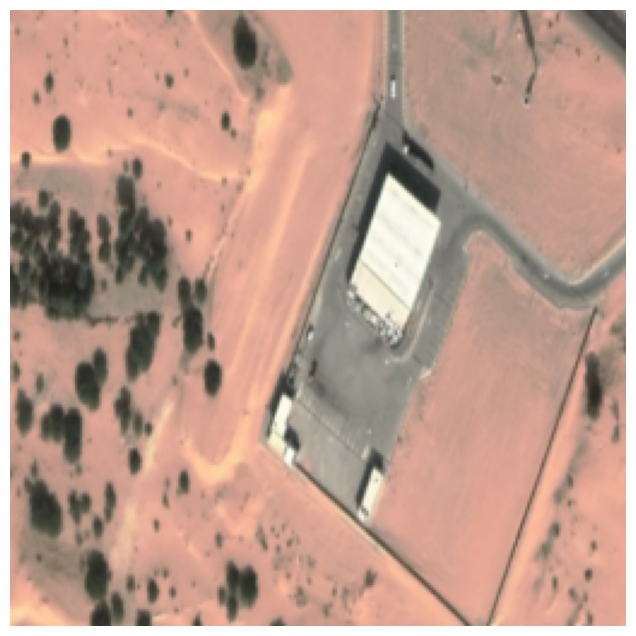

In [8]:
show_tensor_images(img[10])

#### Variational AutoEncoder Blocks 

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=512, input_channels=3, hidden_dim=32):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            self.encoder_block(input_channels, hidden_dim),
            self.encoder_block(hidden_dim, hidden_dim * 2),
            self.encoder_block(hidden_dim * 2, hidden_dim * 4),
            self.encoder_block(hidden_dim * 4, hidden_dim * 8),
            self.encoder_block(hidden_dim * 8, hidden_dim * 16),
            self.encoder_block(hidden_dim * 16, hidden_dim * 32),
            self.encoder_block(hidden_dim * 32, latent_dim * 2, final_layer=True),
        )
        
    def encoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False): 
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
            )
        
    def forward(self, image):
        encoded = self.encoder(image)
        encoding = encoded.view(encoded.size(0), -1)

        mean = encoding[:, :self.latent_dim]
        stddev = torch.exp(0.5 * encoding[:, self.latent_dim:]) + 1e-8 
        return mean, stddev
    
    def get_encoder(self):
        return self.encoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=512, output_channels=3, hidden_dim=32):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.decoder = nn.Sequential(
            self.decoder_block(latent_dim, hidden_dim * 64),  
            self.decoder_block(hidden_dim * 64, hidden_dim * 32),  
            self.decoder_block(hidden_dim * 32, hidden_dim * 16),  
            self.decoder_block(hidden_dim * 16, hidden_dim * 8), 
            self.decoder_block(hidden_dim * 8, hidden_dim * 4),  
            self.decoder_block(hidden_dim * 4, hidden_dim * 2),  
            self.decoder_block(hidden_dim * 2, hidden_dim),  
            self.decoder_block(hidden_dim, output_channels, final_layer=True)
        )
        
    def decoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Sigmoid() 
            )
        
    def forward(self, noise):
        x = noise.view(len(noise), self.latent_dim, 1, 1) 
        return self.decoder(x)

In [11]:
class Variational_AutoEncoder(nn.Module):
    def __init__(self, latent_dim=512, image_channels=3):
        super(Variational_AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = Encoder(input_channels=image_channels, latent_dim=latent_dim)
        self.decode = Decoder(latent_dim=latent_dim, output_channels=image_channels)
        
        self.encode = self.encode.apply(weights_init)
        self.decode = self.decode.apply(weights_init)

    def forward(self, images):
        mean, stddev = self.encode(images)
        dist = Normal(mean, stddev)
        latent_sample = dist.rsample() 
        decoded = self.decode(latent_sample)
        return decoded, dist

In [12]:
reconstruction_loss = nn.BCELoss(reduction='sum')

def kl_divergence_loss(dist):
    return kl_divergence(dist, Normal(torch.zeros_like(dist.mean), torch.ones_like(dist.stddev))).sum(-1)

In [17]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

In [15]:
device = 'cuda'
lr = 0.002
batch_size = 64 
epochs = 10 

vae = Variational_AutoEncoder().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=lr)

Epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.01s/it]


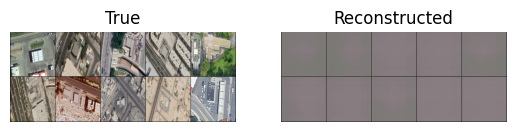

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  3.00s/it]


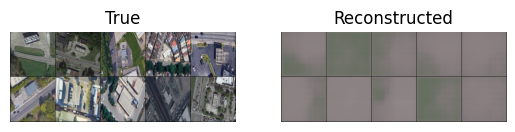

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.05s/it]


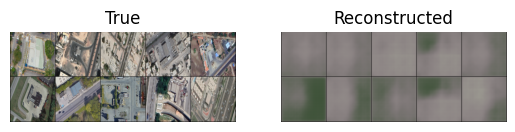

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.15s/it]


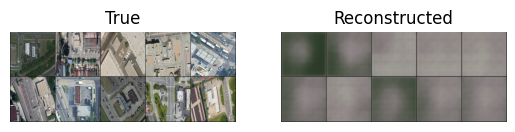

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.09s/it]


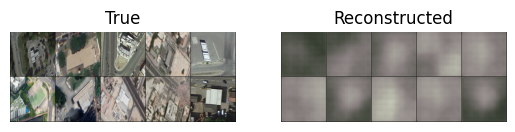

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.08s/it]


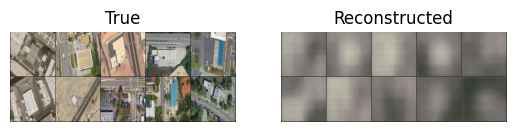

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.10s/it]


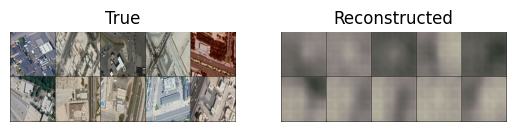

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.17s/it]


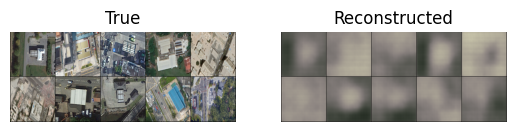

Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.07s/it]


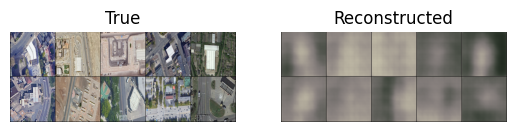

Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.18s/it]


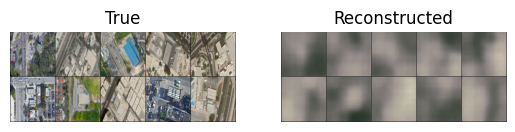

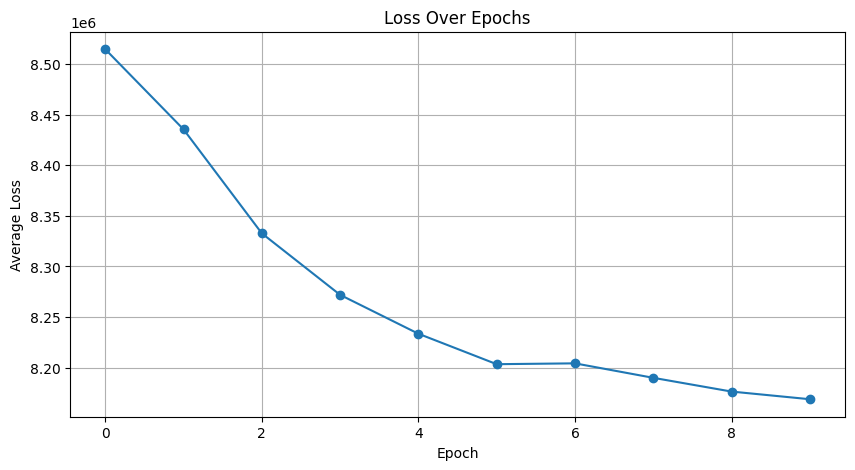

In [18]:
losses = [] 

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    total_loss = 0
    total_samples = 0 

    for images in tqdm(dataloader):
        images = images.to(device)
        vae_opt.zero_grad() 
        recon_images, encoding = vae(images)
        
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        
        vae_opt.step()
        
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        
    average_loss = total_loss / total_samples
    losses.append(average_loss)
    
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")

    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    
    plt.show()
    
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()